In [1]:
import sys
sys.path.append('../pyorderedfuzzy')

In [2]:
import numpy as np
import pandas as pd
import ofclassifiers as ofcls
import ofnumber as ofn
import ofmodels as ofm
import ofrandom as ofr
import matplotlib.pylab as plt
import tensorflow as tf
from keras.initializers import Initializer
from keras.models import Model
from keras.layers import Input, Lambda, Dense, Add, Concatenate, Minimum, Dropout, Maximum, Subtract
from keras import backend as K

Using TensorFlow backend.


In [3]:
nvar = 2
nsample = 600
dim = 11

In [4]:
c0 = np.random.multivariate_normal(np.array([-0.5, 0.5]), np.array([[0.01, 0],[0,0.01]]), size=nsample//2)
c1 = np.random.multivariate_normal(np.array([0.5, -0.5]), np.array([[0.01, 0],[0,0.01]]), size=nsample//2)
data = np.concatenate([c0, c1])
d = np.concatenate([np.zeros((nsample//2, 2*dim)), np.ones((nsample//2,2*dim))])
d = np.concatenate([np.zeros(nsample//2, dtype=np.int), np.ones(nsample//2, dtype=np.int)])
temp = np.arange(nsample)
np.random.shuffle(temp)
data = data[temp]
d = d[temp]

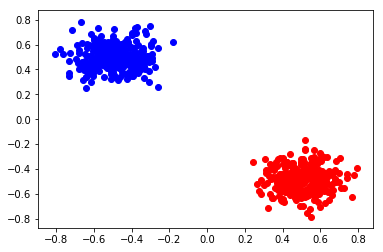

In [5]:
fig, ax = plt.subplots()
ax.scatter(c0[:,0], c0[:,1], c='b')
ax.scatter(c1[:,0], c1[:,1], c='r')
plt.show()

In [6]:
#vfunc = np.vectorize(lambda x: ofn.OFNumber.init_from_scalar(x, dim=dim), otypes=[ofn.OFNumber])
vfunc = np.vectorize(lambda x: ofn.OFNumber.init_gaussian(x,-0.005, x, 0.005, dim=dim), otypes=[ofn.OFNumber])
fdata = ofm.OFSeries(vfunc(data))

In [7]:
fdata = fdata.to_array(stack='hstack')
fdata = np.array(list(map(list, fdata)), dtype=np.float32)
fdata.shape

(600, 2, 22)

In [8]:
fweights = ofr.ofnormal_sample(3, ofn.OFNumber.init_gaussian(0,-0.5, 0, 0.5, dim=dim), 
                               ofn.OFNumber.init_from_scalar(0.0, dim=dim), 1, 0.5)

In [9]:
fweights = fweights.to_array(stack='hstack')
fweights = np.array(list(map(list, fweights)), dtype=np.float32)
fweights.shape

(3, 22)

In [10]:
def fsplit(tensor):
    shape = list(tensor.shape)
    return [tensor[:,:,i] for i in range(shape[2])]

def fsplit_output_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 3
    return [tuple([shape[0], shape[1]]) for _ in range(shape[2])]

class MyInit(Initializer):
    def __init__(self, weights):
        self.weights = weights
    def __call__(self, shape, dtype=None):
        return K.variable(self.weights, dtype=dtype)
    def get_config(self):
        return {'weights': self.weights}

In [11]:
x = Input(shape=(nvar,2*dim), dtype=K.floatx())
splits = Lambda(fsplit, output_shape=fsplit_output_shape)(x)
neurons = []
for i in range(2*dim):
    neurons.append(Dense(1, activation='sigmoid', bias_initializer=MyInit(weights=fweights[0:1,i]),
                         kernel_initializer=MyInit(weights=fweights[1:,i].reshape((2,1))))(splits[i]))
#o = Add()(neurons)
y = Concatenate()(neurons)
#y = Minimum()(neurons)
#y = Lambda(expected, output_shape=expected_output_shape)(c)
#y = Lambda(lambda x: 0.5*0.1*x)(o)

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
def fmse(y_true, y_pred):
    return K.mean(K.mean(K.square(y_pred - y_true), axis=1), axis=-1)

def faccuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)), axis=-1)

In [13]:
model = Model(inputs=x, outputs=y)
model.compile(optimizer='adam', loss=fmse, metrics=[faccuracy])

In [20]:
model.fit(fdata, d, epochs=100, verbose=2)

Epoch 1/100
 - 0s - loss: 0.0531 - faccuracy: 0.9773
Epoch 2/100
 - 0s - loss: 0.0520 - faccuracy: 0.9773
Epoch 3/100
 - 0s - loss: 0.0510 - faccuracy: 0.9773
Epoch 4/100
 - 0s - loss: 0.0499 - faccuracy: 0.9773
Epoch 5/100
 - 0s - loss: 0.0488 - faccuracy: 0.9773
Epoch 6/100
 - 0s - loss: 0.0478 - faccuracy: 0.9773
Epoch 7/100
 - 0s - loss: 0.0469 - faccuracy: 0.9773
Epoch 8/100
 - 0s - loss: 0.0459 - faccuracy: 0.9777
Epoch 9/100
 - 0s - loss: 0.0450 - faccuracy: 0.9779
Epoch 10/100
 - 0s - loss: 0.0441 - faccuracy: 0.9791
Epoch 11/100
 - 0s - loss: 0.0432 - faccuracy: 0.9808
Epoch 12/100
 - 0s - loss: 0.0424 - faccuracy: 0.9832
Epoch 13/100
 - 0s - loss: 0.0416 - faccuracy: 0.9863
Epoch 14/100
 - 0s - loss: 0.0408 - faccuracy: 0.9886
Epoch 15/100
 - 0s - loss: 0.0400 - faccuracy: 0.9909
Epoch 16/100
 - 0s - loss: 0.0392 - faccuracy: 0.9936
Epoch 17/100
 - 0s - loss: 0.0385 - faccuracy: 0.9958
Epoch 18/100
 - 0s - loss: 0.0378 - faccuracy: 0.9977
Epoch 19/100
 - 0s - loss: 0.0371 - f

<IPython.core.display.Javascript object>


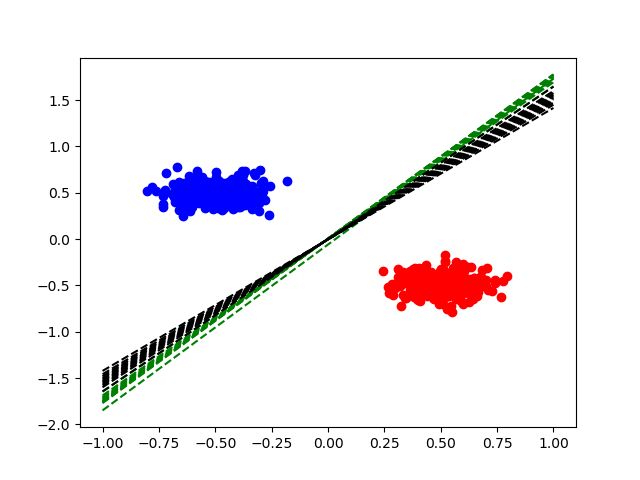

In [21]:
%matplotlib notebook
xx = np.linspace(-1,1,1000)

fig, ax = plt.subplots()
ax.scatter(c0[:,0], c0[:,1], c='b')
ax.scatter(c1[:,0], c1[:,1], c='r')


for i in range(2,24):
    wb = model.layers[i].get_weights()
    w = wb[0].reshape(2)
    b = wb[1]
    if i > 12:
        ax.plot(xx, (-w[0]/w[1]) * xx + (-b/w[1]), 'k--')
    else:
        ax.plot(xx, (-w[0]/w[1]) * xx + (-b/w[1]), 'g--')
plt.show()

In [16]:
model.evaluate(fdata, d)

600/600 [==============================] - 0s 699us/step


[0.05366857906182607, 0.9772727433840434]

In [17]:
y_pred_np = model.predict(fdata)
y_pred_np, d

(array([[0.13530174, 0.17233098, 0.17903438, ..., 0.09572366, 0.10521027,
         0.12597254],
        [0.36012268, 0.7080703 , 0.7455141 , ..., 0.8752157 , 0.86441386,
         0.84011984],
        [0.316585  , 0.6461988 , 0.6857537 , ..., 0.82253563, 0.81050545,
         0.78411496],
        ...,
        [0.1681728 , 0.24884629, 0.26245928, ..., 0.18639404, 0.19717136,
         0.21913174],
        [0.1696527 , 0.23174408, 0.24240622, ..., 0.15150702, 0.16308957,
         0.18746033],
        [0.16009769, 0.22686976, 0.23828802, ..., 0.15612501, 0.16698521,
         0.18958539]], dtype=float32),
 array([0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
        1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
        0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 1, 1, 0, 0

In [18]:
y_true1 = K.variable(d)
y_pred1 = K.variable(y_pred_np)
acc = faccuracy(y_true1, y_pred1)

ValueError: Dimensions must be equal, but are 600 and 22 for 'Equal' (op: 'Equal') with input shapes: [600], [600,22].

In [ ]:
with sess.as_default():
    a = acc.eval()
    print(a)

In [ ]:
model.summary()